# Coming from TensorFlow to NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for
people who are familiar with TensorFlow and looking to learn more about neuromorphic
modelling with NengoDL.  For the other approach, users familiar with Nengo looking to
learn how to use NengoDL, check out [this
tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

If you are familiar with Keras you may also be interested in
[KerasSpiking](https://www.nengo.ai/keras-spiking/), a companion project to NengoDL
that has a more minimal feature set, but integrates even more transparently with the
Keras API. See [this page](https://www.nengo.ai/keras-spiking/nengo-dl-comparison.html)
for a more detailed comparison between the two projects.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you
would want to use it.  Nengo is a tool for constructing and simulating neural networks.
That is, to some extent, the same purpose as TensorFlow (and its higher level API,
Keras).  For example, here is how we might build a simple two layer auto-encoder network
in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and
the creation of the connections between layers.  This is because the connection
structure in Nengo networks often has a lot more state and general complexity than in
typical deep learning networks, so it is helpful to be able to control it independently
(we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data
from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we
want to collect the activities of those neurons when the simulation is running.  You can
think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality
available, but we will focus on the features most familiar or relevant to those coming
from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the
Nengo-specific [documentation](https://www.nengo.ai/nengo/) and
[examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
out = model.predict(np.ones((minibatch_size, n_in)))
print(out.shape)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 2ms/step


(50, 784)


Again, accomplishing the same thing in Nengo bears many similarities.  We create a
`Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 1, n_in)))
    print(out[p_c].shape)

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 315ms/step


(50, 1, 784)


One difference you may note is the extra dimension with size 1 in the shape of the Nengo
inputs and outputs.  This represents the time dimension; in this example we're only
running for a
single timestep, which is why it has size 1, but this could be used to provide different
input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are
fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an
abstract set of computations, in Nengo we (almost) always think of the graph as
representing a stateful neural simulation, where values are accumulated, updated, and
communicated over time.  This is not to say there is no overlap (we can create
TensorFlow simulations that execute over time, and we can create Nengo simulations
without temporal dynamics), but this is a different way of thinking about computations
that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily
designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic
networks include features drawn from biological neural networks, in an effort to
understand or recreate the functionality of biological brains.  Note that these models
fall on a spectrum with standard artificial neural networks, with different approaches
incorporating different biological features.  But in general the structure and
parameterization of these networks often differs significantly from standard deep
network architectures.

We touched on this above in the discussion of temporality, which is one common feature
of neuromorphic networks.  Another common characteristic is the use of more complicated
neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like
`relu`) that output a continuous value, spiking neurons communicate via discrete bursts
of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll
use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps`
(or `sim.run`) is a standard Nengo Simulator execution function (as opposed to
`sim.predict`, which is specific to NengoDL).  We could use either one, but you will
probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in
this case is that results will be stored in the `sim.data` dictionary, as opposed to
being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (40%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

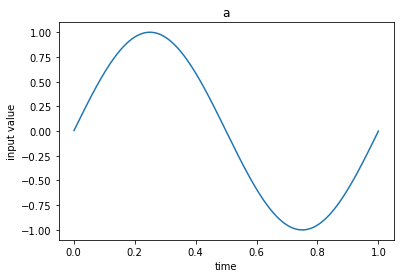

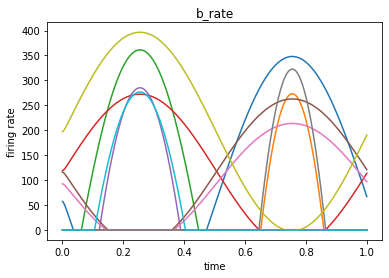

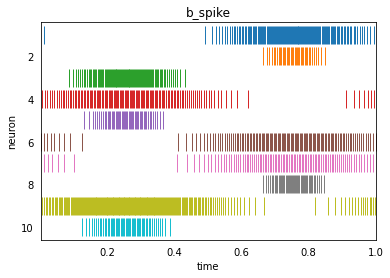

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))

    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)

    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)

    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)

with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")

plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike")
plt.show()

Each neuron responds to the input signal differently due to the random parameterization
in the network (e.g. connection weights and biases).  We have matched the
parameterization in the rate and spiking ensembles so that it is easier to see the
parallels.

Note that the same information is being represented in the two ensembles.  For example,
when the second neuron (orange) is outputting a high continuous value (in the second
graph), the corresponding spiking neuron is outputting more discrete spikes (orange
lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic
filters.  This is inspired by a biological feature where discrete spikes induce a
continuous electrical waveform in the receiving neuron, at the synapse (the point where
the two neurons connect).  But computationally we can think of this simply as applying a
filter to the spiking signal.

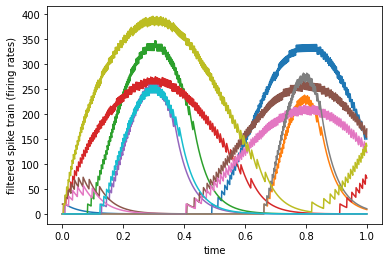

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)")
plt.show()

We can see how the spike trains, when viewed through a synaptic filter, approximate the
continuous rate values in the second graph above.

In this example we have computed the filtered signal manually for demonstration
purposes, but in a typical Nengo model these synaptic filters are applied throughout the
model, on the `Connection` objects.  For example, the above filtering would be
equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective
of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and
Nengo from a standard deep network background.  Although spiking neurons seem like a
radically different paradigm, they can compute and communicate the same information as
their rate counterparts.  But note that this only makes sense when we think of the
network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the
documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete
list).  These neuron models have various different behaviours, and managing their
parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly
work together.  Thus one important feature is the ability to write TensorFlow code
directly, and insert it into a Nengo network.  This allows us to use whichever framework
is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us
to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the
rest of a Nengo model.  The TensorFlow code is written in a function that takes
`tf.Tensors` as input, applies the desired manipulations through TensorFlow operations,
and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for
constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose
we want to apply batch normalization to the output of one of the Nengo ensembles.  There
is no built-in way to do batch normalization in Nengo, so we can instead turn to
TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(tf.keras.layers.BatchNormalization(momentum=0.9))(
        b_rate.neurons
    )
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`,
except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this
case, and we can add Probes or Connections to `batch_norm` in the same way as any other
Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and
`Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9),
        shape_in=(10,),
        pass_time=False,
    )
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write
ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the
current simulation time and `x` is the value of any Connections incoming to the
TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have
shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the
`TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The
`TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,)
+ shape_out`, where `shape_out` is the output dimensionality of the node (dependent on
the manipulations applied to the inputs `x`).  We could explicitly specify
`shape_out=(10,)` in the above example, or if we don't specify the output shape it will
be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1])

    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)

        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)

    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), shape_out=(2,))
    nengo.Connection(a, b, synapse=None)

    p = nengo.Probe(b)

with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

TensorNode input:
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 159ms/step


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation
time over the 10 timesteps we executed, and `x` contains the value of the input Node
that we connected to the TensorNode.  And we can see in the probe data that the
TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This
can be useful, for example, if the TensorNode requires internal parameters (which should
be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:

    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))

        def call(self, inputs):
            return inputs * self.w

    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), pass_time=False)

More details on TensorNode usage can be found in [the user
guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms,
through the `Simulator.fit` function.  Returning to the autoencoder examples from the
beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Epoch 1/2


   1/1875 [..............................] - ETA: 10:53 - loss: 6626.0562

  30/1875 [..............................] - ETA: 3s - loss: 4519.0640   

  59/1875 [..............................] - ETA: 3s - loss: 3895.8701

  87/1875 [>.............................] - ETA: 3s - loss: 3493.5425

 116/1875 [>.............................] - ETA: 3s - loss: 3222.2766

 145/1875 [=>............................] - ETA: 3s - loss: 3017.3560

 173/1875 [=>............................] - ETA: 3s - loss: 2866.8840

 201/1875 [==>...........................] - ETA: 2s - loss: 2742.4629

 230/1875 [==>...........................] - ETA: 2s - loss: 2634.7014

 259/1875 [===>..........................] - ETA: 2s - loss: 2542.9924

 288/1875 [===>..........................] - ETA: 2s - loss: 2463.5889

 317/1875 [====>.........................] - ETA: 2s - loss: 2395.8982

 346/1875 [====>.........................] - ETA: 2s - loss: 2335.0381

 375/1875 [=====>........................] - ETA: 2s - loss: 2282.3718

 404/1875 [=====>........................] - ETA: 2s - loss: 2233.6860

 433/1875 [=====>........................] - ETA: 2s - loss: 2189.1660

 462/1875 [======>.......................] - ETA: 2s - loss: 2151.7373

 491/1875 [======>.......................] - ETA: 2s - loss: 2115.7473

 520/1875 [=======>......................] - ETA: 2s - loss: 2081.6313

 549/1875 [=======>......................] - ETA: 2s - loss: 2052.1494

 578/1875 [========>.....................] - ETA: 2s - loss: 2023.5913

 607/1875 [========>.....................] - ETA: 2s - loss: 1996.0135

 636/1875 [=========>....................] - ETA: 2s - loss: 1971.0295

 665/1875 [=========>....................] - ETA: 2s - loss: 1949.6818

 694/1875 [==========>...................] - ETA: 2s - loss: 1927.4231

 723/1875 [==========>...................] - ETA: 2s - loss: 1906.9868

 752/1875 [===========>..................] - ETA: 1s - loss: 1887.4413

 781/1875 [===========>..................] - ETA: 1s - loss: 1870.6030

 810/1875 [===========>..................] - ETA: 1s - loss: 1854.5276

 839/1875 [============>.................] - ETA: 1s - loss: 1837.9955

 868/1875 [============>.................] - ETA: 1s - loss: 1822.7062

 897/1875 [=============>................] - ETA: 1s - loss: 1808.0273

 926/1875 [=============>................] - ETA: 1s - loss: 1793.9841

 955/1875 [==============>...............] - ETA: 1s - loss: 1779.8616

 984/1875 [==============>...............] - ETA: 1s - loss: 1767.3896

1013/1875 [===============>..............] - ETA: 1s - loss: 1755.8368

1042/1875 [===============>..............] - ETA: 1s - loss: 1744.0588

1071/1875 [================>.............] - ETA: 1s - loss: 1733.4669

1100/1875 [================>.............] - ETA: 1s - loss: 1722.2859

1129/1875 [=================>............] - ETA: 1s - loss: 1711.9597

1158/1875 [=================>............] - ETA: 1s - loss: 1701.5798

1187/1875 [=================>............] - ETA: 1s - loss: 1692.1279

1215/1875 [==================>...........] - ETA: 1s - loss: 1683.8782

1244/1875 [==================>...........] - ETA: 1s - loss: 1675.5146

1272/1875 [===================>..........] - ETA: 1s - loss: 1667.0109

1301/1875 [===================>..........] - ETA: 1s - loss: 1659.0381

1330/1875 [====================>.........] - ETA: 0s - loss: 1651.8740

1359/1875 [====================>.........] - ETA: 0s - loss: 1644.7300

1388/1875 [=====================>........] - ETA: 0s - loss: 1638.4703

1417/1875 [=====================>........] - ETA: 0s - loss: 1630.2631

1446/1875 [======================>.......] - ETA: 0s - loss: 1623.6349

1474/1875 [======================>.......] - ETA: 0s - loss: 1616.9879

1503/1875 [=======================>......] - ETA: 0s - loss: 1609.4871

1532/1875 [=======================>......] - ETA: 0s - loss: 1603.5291

1561/1875 [=======================>......] - ETA: 0s - loss: 1597.3788

1591/1875 [========================>.....] - ETA: 0s - loss: 1591.6787

1620/1875 [========================>.....] - ETA: 0s - loss: 1586.7266

1650/1875 [=========================>....] - ETA: 0s - loss: 1581.3021

1679/1875 [=========================>....] - ETA: 0s - loss: 1575.6064

1709/1875 [==========================>...] - ETA: 0s - loss: 1570.3805

1738/1875 [==========================>...] - ETA: 0s - loss: 1565.2114

1767/1875 [===========================>..] - ETA: 0s - loss: 1559.5037

1796/1875 [===========================>..] - ETA: 0s - loss: 1554.2173

1825/1875 [============================>.] - ETA: 0s - loss: 1549.1337

1852/1875 [============================>.] - ETA: 0s - loss: 1544.3071

1875/1875 [==============================] - 4s 2ms/step - loss: 1540.4279


Epoch 2/2


   1/1875 [..............................] - ETA: 4s - loss: 1207.6562

  30/1875 [..............................] - ETA: 3s - loss: 1218.9298

  59/1875 [..............................] - ETA: 3s - loss: 1210.8234

  88/1875 [>.............................] - ETA: 3s - loss: 1213.7257

 118/1875 [>.............................] - ETA: 3s - loss: 1205.7056

 146/1875 [=>............................] - ETA: 3s - loss: 1203.5095

 174/1875 [=>............................] - ETA: 3s - loss: 1206.1171

 203/1875 [==>...........................] - ETA: 2s - loss: 1204.0463

 232/1875 [==>...........................] - ETA: 2s - loss: 1198.5535

 261/1875 [===>..........................] - ETA: 2s - loss: 1198.4786

 289/1875 [===>..........................] - ETA: 2s - loss: 1203.2351

 318/1875 [====>.........................] - ETA: 2s - loss: 1204.6202

 347/1875 [====>.........................] - ETA: 2s - loss: 1205.0634

 376/1875 [=====>........................] - ETA: 2s - loss: 1206.2816

 405/1875 [=====>........................] - ETA: 2s - loss: 1205.4027

 433/1875 [=====>........................] - ETA: 2s - loss: 1205.2380

 462/1875 [======>.......................] - ETA: 2s - loss: 1204.5273

 491/1875 [======>.......................] - ETA: 2s - loss: 1202.4752

 520/1875 [=======>......................] - ETA: 2s - loss: 1201.7697

 549/1875 [=======>......................] - ETA: 2s - loss: 1200.6254

 578/1875 [========>.....................] - ETA: 2s - loss: 1200.5990

 607/1875 [========>.....................] - ETA: 2s - loss: 1198.2855

 636/1875 [=========>....................] - ETA: 2s - loss: 1196.9440

 665/1875 [=========>....................] - ETA: 2s - loss: 1195.3521

 694/1875 [==========>...................] - ETA: 2s - loss: 1194.6149

 723/1875 [==========>...................] - ETA: 2s - loss: 1195.8517

 745/1875 [==========>...................] - ETA: 2s - loss: 1195.6775

 774/1875 [===========>..................] - ETA: 1s - loss: 1195.6229

 803/1875 [===========>..................] - ETA: 1s - loss: 1195.2838

 831/1875 [============>.................] - ETA: 1s - loss: 1194.7323

 860/1875 [============>.................] - ETA: 1s - loss: 1194.9655

 889/1875 [=============>................] - ETA: 1s - loss: 1194.6836

 918/1875 [=============>................] - ETA: 1s - loss: 1193.8420

 947/1875 [==============>...............] - ETA: 1s - loss: 1193.0743

 976/1875 [==============>...............] - ETA: 1s - loss: 1193.1151

1004/1875 [===============>..............] - ETA: 1s - loss: 1193.0312

1033/1875 [===============>..............] - ETA: 1s - loss: 1192.5138

1062/1875 [===============>..............] - ETA: 1s - loss: 1192.6935

1091/1875 [================>.............] - ETA: 1s - loss: 1193.1378

1120/1875 [================>.............] - ETA: 1s - loss: 1192.8658

1149/1875 [=================>............] - ETA: 1s - loss: 1192.9565

1178/1875 [=================>............] - ETA: 1s - loss: 1193.1578

1207/1875 [==================>...........] - ETA: 1s - loss: 1193.1367

1236/1875 [==================>...........] - ETA: 1s - loss: 1192.4279

1266/1875 [===================>..........] - ETA: 1s - loss: 1191.3685

1295/1875 [===================>..........] - ETA: 1s - loss: 1191.2881

1324/1875 [====================>.........] - ETA: 0s - loss: 1190.4785

1353/1875 [====================>.........] - ETA: 0s - loss: 1190.0123

1382/1875 [=====================>........] - ETA: 0s - loss: 1189.5881

1411/1875 [=====================>........] - ETA: 0s - loss: 1188.7014

1440/1875 [======================>.......] - ETA: 0s - loss: 1187.8167

1469/1875 [======================>.......] - ETA: 0s - loss: 1187.2240

1498/1875 [======================>.......] - ETA: 0s - loss: 1186.3567

1527/1875 [=======================>......] - ETA: 0s - loss: 1186.2029

1556/1875 [=======================>......] - ETA: 0s - loss: 1185.0939

1584/1875 [========================>.....] - ETA: 0s - loss: 1184.1410

1613/1875 [========================>.....] - ETA: 0s - loss: 1183.0265

1642/1875 [=========================>....] - ETA: 0s - loss: 1181.8221

1670/1875 [=========================>....] - ETA: 0s - loss: 1180.7992

1699/1875 [==========================>...] - ETA: 0s - loss: 1180.2563

1728/1875 [==========================>...] - ETA: 0s - loss: 1179.3286

1757/1875 [===========================>..] - ETA: 0s - loss: 1178.7656

1786/1875 [===========================>..] - ETA: 0s - loss: 1177.5502

1815/1875 [============================>.] - ETA: 0s - loss: 1176.3593

1844/1875 [============================>.] - ETA: 0s - loss: 1175.6177

1872/1875 [============================>.] - ETA: 0s - loss: 1174.5222

1875/1875 [==============================] - 3s 2ms/step - loss: 1174.5592


  1/313 [..............................] - ETA: 31s - loss: 1070.2745

 37/313 [==>...........................] - ETA: 0s - loss: 1083.1371 

 73/313 [=====>........................] - ETA: 0s - loss: 1078.1093

108/313 [=========>....................] - ETA: 0s - loss: 1075.8260

143/313 [============>.................] - ETA: 0s - loss: 1084.8788

175/313 [===============>..............] - ETA: 0s - loss: 1087.8914

211/313 [===================>..........] - ETA: 0s - loss: 1114.1051

247/313 [======================>.......] - ETA: 0s - loss: 1125.3374

283/313 [==========================>...] - ETA: 0s - loss: 1148.4771

313/313 [==============================] - 1s 1ms/step - loss: 1154.4677


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


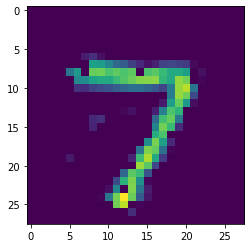

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)))
plt.show()

Before running the same training in NengoDL, we'll change the Nengo model parameters to
more closely match the TensorFlow network (we omitted these details in the original
presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are
essentially temporal, so data is described over time (indicating what the inputs/targets
should be on each simulation timestep).  So instead of the data having shape
`(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll
just be training for a single timestep, but we still need to add that extra axis with
length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training (note: the
results will not match exactly due to different random initializations):

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

| #               Optimizing graph: merging operators                 | 0:00:00

| #                        Optimizing graph                           | 0:00:00

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/2


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

   1/1200 [..............................] - ETA: 21:56 - loss: 7135.3989 - probe_loss: 7135.3989

  14/1200 [..............................] - ETA: 4s - loss: 4987.4927 - probe_loss: 4987.4927   

  27/1200 [..............................] - ETA: 4s - loss: 4348.3413 - probe_loss: 4348.3413

  40/1200 [>.............................] - ETA: 4s - loss: 3964.6707 - probe_loss: 3964.6707

  53/1200 [>.............................] - ETA: 4s - loss: 3649.3716 - probe_loss: 3649.3716

  67/1200 [>.............................] - ETA: 4s - loss: 3381.8218 - probe_loss: 3381.8218

  80/1200 [=>............................] - ETA: 4s - loss: 3199.2502 - probe_loss: 3199.2502

  94/1200 [=>............................] - ETA: 4s - loss: 3035.1650 - probe_loss: 3035.1650

 107/1200 [=>............................] - ETA: 4s - loss: 2912.3501 - probe_loss: 2912.3501

 120/1200 [==>...........................] - ETA: 4s - loss: 2796.1279 - probe_loss: 2796.1279

 132/1200 [==>...........................] - ETA: 4s - loss: 2705.5112 - probe_loss: 2705.5112

 145/1200 [==>...........................] - ETA: 4s - loss: 2619.3699 - probe_loss: 2619.3699

 158/1200 [==>...........................] - ETA: 4s - loss: 2543.7043 - probe_loss: 2543.7043

 171/1200 [===>..........................] - ETA: 4s - loss: 2472.3481 - probe_loss: 2472.3481

 184/1200 [===>..........................] - ETA: 4s - loss: 2409.6108 - probe_loss: 2409.6108

 197/1200 [===>..........................] - ETA: 3s - loss: 2350.5608 - probe_loss: 2350.5608

 210/1200 [====>.........................] - ETA: 3s - loss: 2300.2688 - probe_loss: 2300.2688

 223/1200 [====>.........................] - ETA: 3s - loss: 2249.8447 - probe_loss: 2249.8447

 236/1200 [====>.........................] - ETA: 3s - loss: 2205.9517 - probe_loss: 2205.9517

 249/1200 [=====>........................] - ETA: 3s - loss: 2163.7129 - probe_loss: 2163.7129

 262/1200 [=====>........................] - ETA: 3s - loss: 2124.0674 - probe_loss: 2124.0674

 275/1200 [=====>........................] - ETA: 3s - loss: 2087.3928 - probe_loss: 2087.3928

 288/1200 [======>.......................] - ETA: 3s - loss: 2054.5042 - probe_loss: 2054.5042

 301/1200 [======>.......................] - ETA: 3s - loss: 2022.8409 - probe_loss: 2022.8409

 314/1200 [======>.......................] - ETA: 3s - loss: 1990.9679 - probe_loss: 1990.9679

 327/1200 [=======>......................] - ETA: 3s - loss: 1962.0150 - probe_loss: 1962.0150

 340/1200 [=======>......................] - ETA: 3s - loss: 1934.0549 - probe_loss: 1934.0549

 353/1200 [=======>......................] - ETA: 3s - loss: 1908.4966 - probe_loss: 1908.4966

 366/1200 [========>.....................] - ETA: 3s - loss: 1883.6489 - probe_loss: 1883.6489

 379/1200 [========>.....................] - ETA: 3s - loss: 1859.2225 - probe_loss: 1859.2225

 392/1200 [========>.....................] - ETA: 3s - loss: 1837.0024 - probe_loss: 1837.0024

 405/1200 [=========>....................] - ETA: 3s - loss: 1814.7938 - probe_loss: 1814.7938

 418/1200 [=========>....................] - ETA: 3s - loss: 1794.6570 - probe_loss: 1794.6570

 431/1200 [=========>....................] - ETA: 3s - loss: 1775.2147 - probe_loss: 1775.2147

 444/1200 [==========>...................] - ETA: 3s - loss: 1756.3148 - probe_loss: 1756.3148

 457/1200 [==========>...................] - ETA: 2s - loss: 1739.0505 - probe_loss: 1739.0505

 470/1200 [==========>...................] - ETA: 2s - loss: 1721.8119 - probe_loss: 1721.8119

 483/1200 [===========>..................] - ETA: 2s - loss: 1704.0669 - probe_loss: 1704.0669

 496/1200 [===========>..................] - ETA: 2s - loss: 1689.3323 - probe_loss: 1689.3323

 507/1200 [===========>..................] - ETA: 2s - loss: 1675.5626 - probe_loss: 1675.5626

 520/1200 [============>.................] - ETA: 2s - loss: 1660.7643 - probe_loss: 1660.7643

 531/1200 [============>.................] - ETA: 2s - loss: 1647.7032 - probe_loss: 1647.7032

 543/1200 [============>.................] - ETA: 2s - loss: 1635.6710 - probe_loss: 1635.6710

 555/1200 [============>.................] - ETA: 2s - loss: 1624.4513 - probe_loss: 1624.4513

 568/1200 [=============>................] - ETA: 2s - loss: 1611.6627 - probe_loss: 1611.6627

 580/1200 [=============>................] - ETA: 2s - loss: 1600.1970 - probe_loss: 1600.1970

 593/1200 [=============>................] - ETA: 2s - loss: 1587.2490 - probe_loss: 1587.2490

 606/1200 [==============>...............] - ETA: 2s - loss: 1575.4116 - probe_loss: 1575.4116

 619/1200 [==============>...............] - ETA: 2s - loss: 1564.2689 - probe_loss: 1564.2689

 632/1200 [==============>...............] - ETA: 2s - loss: 1552.6498 - probe_loss: 1552.6498

 644/1200 [===============>..............] - ETA: 2s - loss: 1543.2914 - probe_loss: 1543.2914

 656/1200 [===============>..............] - ETA: 2s - loss: 1533.5032 - probe_loss: 1533.5032

 669/1200 [===============>..............] - ETA: 2s - loss: 1522.6604 - probe_loss: 1522.6604

 682/1200 [================>.............] - ETA: 2s - loss: 1512.4155 - probe_loss: 1512.4155

 695/1200 [================>.............] - ETA: 2s - loss: 1502.5430 - probe_loss: 1502.5430

 708/1200 [================>.............] - ETA: 1s - loss: 1493.2651 - probe_loss: 1493.2651

 721/1200 [=================>............] - ETA: 1s - loss: 1484.6392 - probe_loss: 1484.6392

 734/1200 [=================>............] - ETA: 1s - loss: 1475.7579 - probe_loss: 1475.7579

 747/1200 [=================>............] - ETA: 1s - loss: 1468.0458 - probe_loss: 1468.0458

 760/1200 [==================>...........] - ETA: 1s - loss: 1458.8475 - probe_loss: 1458.8475

 773/1200 [==================>...........] - ETA: 1s - loss: 1451.1394 - probe_loss: 1451.1394

 786/1200 [==================>...........] - ETA: 1s - loss: 1442.7407 - probe_loss: 1442.7407

 799/1200 [==================>...........] - ETA: 1s - loss: 1435.0950 - probe_loss: 1435.0950

 812/1200 [===================>..........] - ETA: 1s - loss: 1427.4260 - probe_loss: 1427.4260

 825/1200 [===================>..........] - ETA: 1s - loss: 1420.2054 - probe_loss: 1420.2054

 838/1200 [===================>..........] - ETA: 1s - loss: 1412.8378 - probe_loss: 1412.8378

 851/1200 [====================>.........] - ETA: 1s - loss: 1405.9104 - probe_loss: 1405.9104

 863/1200 [====================>.........] - ETA: 1s - loss: 1399.2404 - probe_loss: 1399.2404

 876/1200 [====================>.........] - ETA: 1s - loss: 1391.9407 - probe_loss: 1391.9407

 889/1200 [=====================>........] - ETA: 1s - loss: 1385.1932 - probe_loss: 1385.1932

 902/1200 [=====================>........] - ETA: 1s - loss: 1378.5522 - probe_loss: 1378.5522

 914/1200 [=====================>........] - ETA: 1s - loss: 1372.2596 - probe_loss: 1372.2596

 927/1200 [======================>.......] - ETA: 1s - loss: 1366.2797 - probe_loss: 1366.2797

 940/1200 [======================>.......] - ETA: 1s - loss: 1359.9905 - probe_loss: 1359.9905

 953/1200 [======================>.......] - ETA: 1s - loss: 1353.5389 - probe_loss: 1353.5389

 966/1200 [=======================>......] - ETA: 0s - loss: 1347.9034 - probe_loss: 1347.9034

 979/1200 [=======================>......] - ETA: 0s - loss: 1341.8403 - probe_loss: 1341.8403

 992/1200 [=======================>......] - ETA: 0s - loss: 1336.5099 - probe_loss: 1336.5099

1005/1200 [========================>.....] - ETA: 0s - loss: 1330.7664 - probe_loss: 1330.7664

1018/1200 [========================>.....] - ETA: 0s - loss: 1324.9698 - probe_loss: 1324.9698

1031/1200 [========================>.....] - ETA: 0s - loss: 1319.2231 - probe_loss: 1319.2231

1044/1200 [=========================>....] - ETA: 0s - loss: 1314.4523 - probe_loss: 1314.4523

1057/1200 [=========================>....] - ETA: 0s - loss: 1309.3280 - probe_loss: 1309.3280

1070/1200 [=========================>....] - ETA: 0s - loss: 1304.6117 - probe_loss: 1304.6117

1083/1200 [==========================>...] - ETA: 0s - loss: 1299.5850 - probe_loss: 1299.5850

1093/1200 [==========================>...] - ETA: 0s - loss: 1295.7592 - probe_loss: 1295.7592

1106/1200 [==========================>...] - ETA: 0s - loss: 1291.1671 - probe_loss: 1291.1671

1119/1200 [==========================>...] - ETA: 0s - loss: 1286.2769 - probe_loss: 1286.2769

1132/1200 [===========================>..] - ETA: 0s - loss: 1281.9088 - probe_loss: 1281.9088

1145/1200 [===========================>..] - ETA: 0s - loss: 1276.8181 - probe_loss: 1276.8181

1158/1200 [===========================>..] - ETA: 0s - loss: 1272.5262 - probe_loss: 1272.5262

1171/1200 [============================>.] - ETA: 0s - loss: 1268.1653 - probe_loss: 1268.1653

1184/1200 [============================>.] - ETA: 0s - loss: 1264.1238 - probe_loss: 1264.1238

1197/1200 [============================>.] - ETA: 0s - loss: 1259.5977 - probe_loss: 1259.5977

1200/1200 [==============================] - 6s 4ms/step - loss: 1258.6140 - probe_loss: 1258.6140


Epoch 2/2


   1/1200 [..............................] - ETA: 5s - loss: 973.2262 - probe_loss: 973.2262

  14/1200 [..............................] - ETA: 4s - loss: 884.6346 - probe_loss: 884.6346

  27/1200 [..............................] - ETA: 4s - loss: 882.4787 - probe_loss: 882.4787

  40/1200 [>.............................] - ETA: 4s - loss: 871.1761 - probe_loss: 871.1761

  53/1200 [>.............................] - ETA: 4s - loss: 874.8467 - probe_loss: 874.8467

  66/1200 [>.............................] - ETA: 4s - loss: 878.3907 - probe_loss: 878.3907

  79/1200 [>.............................] - ETA: 4s - loss: 876.8699 - probe_loss: 876.8699

  92/1200 [=>............................] - ETA: 4s - loss: 875.3702 - probe_loss: 875.3702

 105/1200 [=>............................] - ETA: 4s - loss: 871.7358 - probe_loss: 871.7358

 118/1200 [=>............................] - ETA: 4s - loss: 867.9532 - probe_loss: 867.9532

 131/1200 [==>...........................] - ETA: 4s - loss: 866.9470 - probe_loss: 866.9470

 144/1200 [==>...........................] - ETA: 4s - loss: 867.3627 - probe_loss: 867.3627

 157/1200 [==>...........................] - ETA: 4s - loss: 866.5478 - probe_loss: 866.5478

 170/1200 [===>..........................] - ETA: 4s - loss: 866.2260 - probe_loss: 866.2260

 183/1200 [===>..........................] - ETA: 4s - loss: 861.7324 - probe_loss: 861.7324

 196/1200 [===>..........................] - ETA: 4s - loss: 858.0201 - probe_loss: 858.0201

 209/1200 [====>.........................] - ETA: 3s - loss: 857.8104 - probe_loss: 857.8104

 223/1200 [====>.........................] - ETA: 3s - loss: 853.5580 - probe_loss: 853.5580

 236/1200 [====>.........................] - ETA: 3s - loss: 854.2783 - probe_loss: 854.2783

 249/1200 [=====>........................] - ETA: 3s - loss: 852.0457 - probe_loss: 852.0457

 262/1200 [=====>........................] - ETA: 3s - loss: 851.2299 - probe_loss: 851.2299

 275/1200 [=====>........................] - ETA: 3s - loss: 850.9178 - probe_loss: 850.9178

 288/1200 [======>.......................] - ETA: 3s - loss: 850.8741 - probe_loss: 850.8741

 301/1200 [======>.......................] - ETA: 3s - loss: 849.2419 - probe_loss: 849.2419

 314/1200 [======>.......................] - ETA: 3s - loss: 848.0750 - probe_loss: 848.0750

 327/1200 [=======>......................] - ETA: 3s - loss: 847.4172 - probe_loss: 847.4172

 340/1200 [=======>......................] - ETA: 3s - loss: 846.5428 - probe_loss: 846.5428

 353/1200 [=======>......................] - ETA: 3s - loss: 846.8929 - probe_loss: 846.8929

 366/1200 [========>.....................] - ETA: 3s - loss: 846.6581 - probe_loss: 846.6581

 379/1200 [========>.....................] - ETA: 3s - loss: 844.8325 - probe_loss: 844.8325

 392/1200 [========>.....................] - ETA: 3s - loss: 844.9350 - probe_loss: 844.9350

 405/1200 [=========>....................] - ETA: 3s - loss: 845.0903 - probe_loss: 845.0903

 417/1200 [=========>....................] - ETA: 3s - loss: 845.2009 - probe_loss: 845.2009

 430/1200 [=========>....................] - ETA: 3s - loss: 844.2055 - probe_loss: 844.2055

 443/1200 [==========>...................] - ETA: 3s - loss: 844.5195 - probe_loss: 844.5195

 456/1200 [==========>...................] - ETA: 2s - loss: 844.3563 - probe_loss: 844.3563

 469/1200 [==========>...................] - ETA: 2s - loss: 843.6495 - probe_loss: 843.6495

 482/1200 [===========>..................] - ETA: 2s - loss: 842.8594 - probe_loss: 842.8594

 495/1200 [===========>..................] - ETA: 2s - loss: 843.5577 - probe_loss: 843.5577

 507/1200 [===========>..................] - ETA: 2s - loss: 842.4827 - probe_loss: 842.4827

 520/1200 [============>.................] - ETA: 2s - loss: 841.3044 - probe_loss: 841.3044

 533/1200 [============>.................] - ETA: 2s - loss: 841.4024 - probe_loss: 841.4024

 545/1200 [============>.................] - ETA: 2s - loss: 840.3668 - probe_loss: 840.3668

 557/1200 [============>.................] - ETA: 2s - loss: 840.4177 - probe_loss: 840.4177

 570/1200 [=============>................] - ETA: 2s - loss: 839.9933 - probe_loss: 839.9933

 583/1200 [=============>................] - ETA: 2s - loss: 839.2462 - probe_loss: 839.2462

 596/1200 [=============>................] - ETA: 2s - loss: 838.0594 - probe_loss: 838.0594

 609/1200 [==============>...............] - ETA: 2s - loss: 837.4632 - probe_loss: 837.4632

 622/1200 [==============>...............] - ETA: 2s - loss: 836.0232 - probe_loss: 836.0232

 635/1200 [==============>...............] - ETA: 2s - loss: 835.7183 - probe_loss: 835.7183

 648/1200 [===============>..............] - ETA: 2s - loss: 834.7671 - probe_loss: 834.7671

 661/1200 [===============>..............] - ETA: 2s - loss: 833.5876 - probe_loss: 833.5876

 674/1200 [===============>..............] - ETA: 2s - loss: 833.5534 - probe_loss: 833.5534

 686/1200 [================>.............] - ETA: 2s - loss: 832.9340 - probe_loss: 832.9340

 699/1200 [================>.............] - ETA: 2s - loss: 831.3964 - probe_loss: 831.3964

 712/1200 [================>.............] - ETA: 1s - loss: 830.8881 - probe_loss: 830.8881

 724/1200 [=================>............] - ETA: 1s - loss: 829.6630 - probe_loss: 829.6630

 737/1200 [=================>............] - ETA: 1s - loss: 828.6334 - probe_loss: 828.6334

 750/1200 [=================>............] - ETA: 1s - loss: 828.2632 - probe_loss: 828.2632

 763/1200 [==================>...........] - ETA: 1s - loss: 827.6017 - probe_loss: 827.6017

 776/1200 [==================>...........] - ETA: 1s - loss: 826.8179 - probe_loss: 826.8179

 789/1200 [==================>...........] - ETA: 1s - loss: 826.1549 - probe_loss: 826.1549

 802/1200 [===================>..........] - ETA: 1s - loss: 825.4210 - probe_loss: 825.4210

 815/1200 [===================>..........] - ETA: 1s - loss: 824.6537 - probe_loss: 824.6537

 828/1200 [===================>..........] - ETA: 1s - loss: 824.0262 - probe_loss: 824.0262

 841/1200 [====================>.........] - ETA: 1s - loss: 823.0541 - probe_loss: 823.0541

 854/1200 [====================>.........] - ETA: 1s - loss: 822.9673 - probe_loss: 822.9673

 867/1200 [====================>.........] - ETA: 1s - loss: 821.4343 - probe_loss: 821.4343

 878/1200 [====================>.........] - ETA: 1s - loss: 821.0410 - probe_loss: 821.0410

 890/1200 [=====================>........] - ETA: 1s - loss: 820.5162 - probe_loss: 820.5162

 903/1200 [=====================>........] - ETA: 1s - loss: 819.5779 - probe_loss: 819.5779

 916/1200 [=====================>........] - ETA: 1s - loss: 818.8345 - probe_loss: 818.8345

 929/1200 [======================>.......] - ETA: 1s - loss: 818.0764 - probe_loss: 818.0764

 942/1200 [======================>.......] - ETA: 1s - loss: 817.3574 - probe_loss: 817.3574

 955/1200 [======================>.......] - ETA: 0s - loss: 816.8701 - probe_loss: 816.8701

 968/1200 [=======================>......] - ETA: 0s - loss: 815.9131 - probe_loss: 815.9131

 981/1200 [=======================>......] - ETA: 0s - loss: 815.0870 - probe_loss: 815.0870

 994/1200 [=======================>......] - ETA: 0s - loss: 814.5317 - probe_loss: 814.5317

1007/1200 [========================>.....] - ETA: 0s - loss: 813.9443 - probe_loss: 813.9443

1020/1200 [========================>.....] - ETA: 0s - loss: 813.4917 - probe_loss: 813.4917

1032/1200 [========================>.....] - ETA: 0s - loss: 813.0669 - probe_loss: 813.0669

1045/1200 [=========================>....] - ETA: 0s - loss: 812.4384 - probe_loss: 812.4384

1058/1200 [=========================>....] - ETA: 0s - loss: 811.8384 - probe_loss: 811.8384

1070/1200 [=========================>....] - ETA: 0s - loss: 811.7276 - probe_loss: 811.7276

1082/1200 [==========================>...] - ETA: 0s - loss: 810.9648 - probe_loss: 810.9648

1096/1200 [==========================>...] - ETA: 0s - loss: 810.1545 - probe_loss: 810.1545

1109/1200 [==========================>...] - ETA: 0s - loss: 809.7521 - probe_loss: 809.7521

1122/1200 [===========================>..] - ETA: 0s - loss: 809.5402 - probe_loss: 809.5402

1134/1200 [===========================>..] - ETA: 0s - loss: 809.1569 - probe_loss: 809.1569

1143/1200 [===========================>..] - ETA: 0s - loss: 808.9791 - probe_loss: 808.9791

1156/1200 [===========================>..] - ETA: 0s - loss: 808.5815 - probe_loss: 808.5815

1168/1200 [============================>.] - ETA: 0s - loss: 808.2200 - probe_loss: 808.2200

1181/1200 [============================>.] - ETA: 0s - loss: 807.8380 - probe_loss: 807.8380

1195/1200 [============================>.] - ETA: 0s - loss: 806.8973 - probe_loss: 806.8973

1200/1200 [==============================] - 5s 4ms/step - loss: 806.8111 - probe_loss: 806.8111


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/200 [..............................] - ETA: 53s - loss: 743.0246 - probe_loss: 743.0246

 19/200 [=>............................] - ETA: 0s - loss: 780.8938 - probe_loss: 780.8938 

 37/200 [====>.........................] - ETA: 0s - loss: 774.0240 - probe_loss: 774.0240

 55/200 [=======>......................] - ETA: 0s - loss: 776.4107 - probe_loss: 776.4107

 73/200 [=========>....................] - ETA: 0s - loss: 776.3497 - probe_loss: 776.3497

 91/200 [============>.................] - ETA: 0s - loss: 781.4772 - probe_loss: 781.4772

109/200 [===============>..............] - ETA: 0s - loss: 780.2291 - probe_loss: 780.2291

127/200 [==================>...........] - ETA: 0s - loss: 796.7689 - probe_loss: 796.7689

145/200 [====================>.........] - ETA: 0s - loss: 798.8743 - probe_loss: 798.8743

163/200 [=======================>......] - ETA: 0s - loss: 813.2349 - probe_loss: 813.2349

181/200 [==========================>...] - ETA: 0s - loss: 818.8188 - probe_loss: 818.8188

199/200 [============================>.] - ETA: 0s - loss: 822.0847 - probe_loss: 822.0847

200/200 [==============================] - 1s 3ms/step - loss: 822.1825 - probe_loss: 822.1825


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 225ms/step


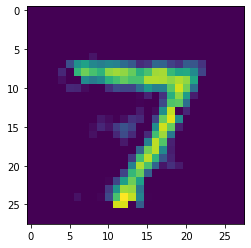

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)))
    plt.show()

More details on using `sim.fit` can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering
Framework (NEF).  This uses linear least-squares optimization to solve for optimal
connection weights analytically, rather than using an iterative gradient-descent based
algorithm.  The advantage of the NEF is that it is very fast and general (for example,
it does not require the network to be differentiable).  The disadvantage is that it
optimizes each set of connection weights individually (i.e., it cannot jointly optimize
across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a
`nengo.Connection`.  This specifies the function that we would like those connection
weights to approximate.  In addition, in previous examples you may have noticed that we
were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using
`ensemble.neurons` specifies that we want to form a direct connection between ensemble
neurons, without applying the NEF optimization.  So when we want to use the `function`
argument, the `Connection` source object should be an `ensemble`, not
`ensemble.neurons`.  For example, we could use the NEF to create a network to
approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

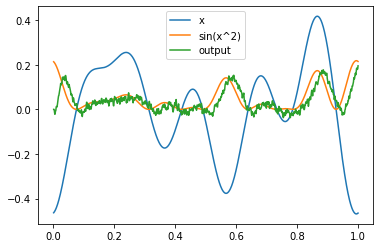

In [17]:
with nengo.Network(seed=0) as net:
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))

    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)

    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)

    # output node
    outpt = nengo.Node(size_in=1)

    # connect input to first ensemble
    nengo.Connection(inpt, ens0)

    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)

    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)

    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt, synapse=0.005)

with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

The NEF optimization can be used in combination with the deep learning optimization
methods.  For example, we could optimize some parameters with the NEF and others with
`sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).
Or we could initialize each set of connection weights individually with the NEF, and
then further refine them with end-to-end training via `sim.fit`.  As always, the overall
theme is that NengoDL allows us to use whichever method is most appropriate for a
particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a
deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic
networks quickly/efficiently.  However, often it is difficult to program this custom
hardware, and it requires writing custom code for each neuromorphic platform.  One of
the primary design goals of Nengo is to alleviate these challenges, by providing a
single API that can be used to build networks across many different neuromorphic
platforms.

The idea is that the front-end network construction code is the same (`Networks`,
`Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own
`Simulator` class (the back-end) that compiles and executes that network definition for
some compute platform.  This provides a consistent interface so that we only need to
write code once and can then run that network on novel hardware platforms with no
additional effort.  For example, we could take the network from above and simulate it on
different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

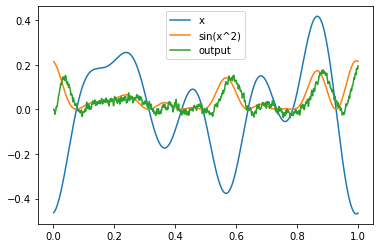

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

# run on Loihi neuromorphic hardware
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo-labs/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

We have commented out the different backends above because they require extra
installation steps, but if you are running this example yourself you can install any of
those backends (or more) and uncomment that code to see the same network running on that
new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end
(among other things); it takes a standard Nengo network, and simulates it using
TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate
NengoDL's deep learning functionality into any other Nengo back-end.  We build our
Network, optimize it in NengoDL, save the optimized model parameters back into the
Network definition, and then simulate that optimized Network in a different back-end.
See [this example in
nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a
spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL,
including network construction, execution, and optimization.  We have also discussed how
to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the
unique features of Nengo (such as NEF optimization and neuromorphic cross-platform
execution).  However, there is much more functionality in NengoDL than we are able to
introduce here; check out the [user
guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other
examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you
would like more information on how NengoDL is implemented under the hood using
TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).